# **Coleta de Imagens de Satélite - São Paulo**
### **Objetivo**: Coletar 300-500 imagens de diferentes regiões de SP para inferência
### **Estratégia**: Amostragem estratificada por região e perfil socioeconômico

## 1. Setup e Imports

In [87]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import requests
from PIL import Image
from io import BytesIO
import json

### Configurações

In [88]:
# Configurações
SEED = 42
np.random.seed(SEED)

OUTPUT_DIR = '../data/sao_paulo/random_method/images'
METADATA_PATH = '../data/sao_paulo/random_method/metadata.csv'
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 2. Definindo Regiões de São Paulo

In [89]:
# Coordenadas aproximadas das regiões de SP
sp_regions = {
    'Centro': {
        'lat_range': (-23.555, -23.535),
        'lon_range': (-46.635, -46.615),
        'description': 'Centro - verticalizado, poucas piscinas',
        'expected_density': 'baixa',
        'n_samples': 50
    },
    'Zona_Oeste': {
        'lat_range': (-23.590, -23.540),
        'lon_range': (-46.750, -46.640),
        'description': 'Zona Oeste - alto padrão, muitas piscinas',
        'expected_density': 'alta',
        'n_samples': 170
    },
    'Zona_Sul': {
        'lat_range': (-23.680, -23.620),
        'lon_range': (-46.700, -46.640),
        'description': 'Zona Sul - misto, densidade média',
        'expected_density': 'média',
        'n_samples': 100
    },
    'Zona_Leste': {
        'lat_range': (-23.580, -23.520),
        'lon_range': (-46.570, -46.510),
        'description': 'Zona Leste - densidade baixa-média',
        'expected_density': 'baixa-média',
        'n_samples': 80
    },
    'Zona_Norte': {
        'lat_range': (-23.510, -23.460),
        'lon_range': (-46.660, -46.610),
        'description': 'Zona Norte - densidade baixa-média',
        'expected_density': 'baixa-média',
        'n_samples': 50
    }
}

In [90]:
# Visualizar regiões
print("=" * 70)
print("REGIÕES DE SÃO PAULO PARA AMOSTRAGEM")
print("=" * 70)
for region, info in sp_regions.items():
    print(f"\n{region}:")
    print(f"  Descrição: {info['description']}")
    print(f"  Densidade esperada: {info['expected_density']}")
    print(f"  Amostras: {info['n_samples']}")

total_samples = sum(r['n_samples'] for r in sp_regions.values())
print(f"\n{'='*70}")
print(f"TOTAL DE IMAGENS A COLETAR: {total_samples}")
print("=" * 70)

REGIÕES DE SÃO PAULO PARA AMOSTRAGEM

Centro:
  Descrição: Centro - verticalizado, poucas piscinas
  Densidade esperada: baixa
  Amostras: 50

Zona_Oeste:
  Descrição: Zona Oeste - alto padrão, muitas piscinas
  Densidade esperada: alta
  Amostras: 170

Zona_Sul:
  Descrição: Zona Sul - misto, densidade média
  Densidade esperada: média
  Amostras: 100

Zona_Leste:
  Descrição: Zona Leste - densidade baixa-média
  Densidade esperada: baixa-média
  Amostras: 80

Zona_Norte:
  Descrição: Zona Norte - densidade baixa-média
  Densidade esperada: baixa-média
  Amostras: 50

TOTAL DE IMAGENS A COLETAR: 450


## 3. Definição da Amostragem Estratificada


✓ 450 pontos de amostragem gerados

Distribuição por região:
region
Zona_Oeste    170
Zona_Sul      100
Zona_Leste     80
Centro         50
Zona_Norte     50
Name: count, dtype: int64


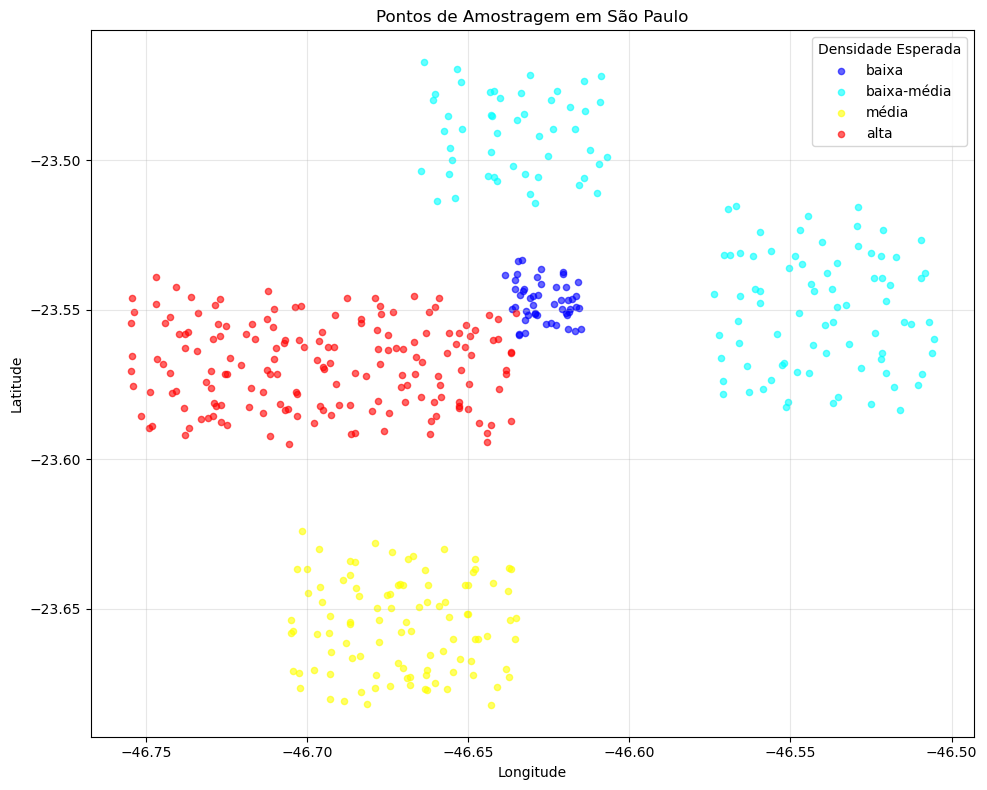

In [95]:
def generate_sampling_points(regions_dict):
    """
    Gera pontos de amostragem estratificados por região
    """
    all_points = []
    
    for region_name, region_info in regions_dict.items():
        lat_min, lat_max = region_info['lat_range']
        lon_min, lon_max = region_info['lon_range']
        n_samples = region_info['n_samples']
        
        # Gerar grid + aleatoriedade
        # Criar grid base
        grid_size = int(np.sqrt(n_samples)) + 1
        lats = np.linspace(lat_min, lat_max, grid_size)
        lons = np.linspace(lon_min, lon_max, grid_size)
        
        # Adicionar ruído aleatório
        points_in_region = []
        for lat in lats:
            for lon in lons:
                if len(points_in_region) >= n_samples:
                    break
                # Adicionar variação aleatória (jitter)
                lat_jitter = np.random.uniform(-0.005, 0.005)
                lon_jitter = np.random.uniform(-0.005, 0.005)
                points_in_region.append({
                    'lat': lat + lat_jitter,
                    'lon': lon + lon_jitter,
                    'region': region_name,
                    'expected_density': region_info['expected_density']
                })
        
        all_points.extend(points_in_region[:n_samples])
    
    return pd.DataFrame(all_points)

# Gerar pontos
sampling_points = generate_sampling_points(sp_regions)
print(f"\n✓ {len(sampling_points)} pontos de amostragem gerados")
print(f"\nDistribuição por região:")
print(sampling_points['region'].value_counts())

# Visualizar
plt.figure(figsize=(10, 8))
colors = {'baixa': 'blue', 'baixa-média': 'cyan', 'média': 'yellow', 'alta': 'red'}
for density, color in colors.items():
    subset = sampling_points[sampling_points['expected_density'] == density]
    plt.scatter(subset['lon'], subset['lat'], c=color, label=density, alpha=0.6, s=20)


save_path = '../results/sp_extract_images/random_method/sampling_points_map.png'
output_dir = os.path.dirname(save_path)
os.makedirs(output_dir, exist_ok=True)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pontos de Amostragem em São Paulo')
plt.legend(title='Densidade Esperada')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(save_path, dpi=150)
plt.show()


## 4. Coleta via Google Maps API


#### COMO OBTER API KEY:

1. Acesse: https://console.cloud.google.com/
2. Crie um projeto novo
3. Ative "Maps Static API"
4. Vá em "Credenciais" > "Criar credenciais" > "Chave de API"
5. Copie a chave
6. Para mais detalhes, consulte o tutorial da Google: https://developers.google.com/maps/documentation/maps-static/get-api-key?hl=pt_BR&setupProd=configure

### Carregando Chave API do arquivo .env

Crie um arquivo .env no ambiente e insira "GOOGLE_API_KEY" juntamente do valor da API. 
(ex: **GOOGLE_API_KEY="YOUR_KEY"**)

In [26]:
from dotenv import load_dotenv
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
dotenv_path = os.path.join(project_root, '.env')

load_dotenv(dotenv_path=dotenv_path)

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")

if GOOGLE_API_KEY is None:
    print("ERRO: Chave 'GOOGLE_API_KEY' não encontrada no arquivo .env")
    raise ValueError("Chave de API não encontrada!")
else:
    print("✓ Chave de API carregada com sucesso do arquivo .env!")

✓ Chave de API carregada com sucesso do arquivo .env!


#### Função de download

In [27]:
def download_google_maps(lat, lon, output_path, zoom=19, size=512):
    """
    Baixa imagem do Google Maps Static API
    
    Args:
        lat, lon: Coordenadas
        output_path: Onde salvar
        zoom: Nível de zoom (1-21)
            - 20: Muito próximo (recomendado para piscinas)
            - 19: Próximo
            - 18: Médio
        size: Tamanho em pixels (máx 640x640 grátis, 2048x2048 premium)
    """
    try:
        base_url = "https://maps.googleapis.com/maps/api/staticmap"
        
        params = {
            'center': f'{lat},{lon}',
            'zoom': zoom,
            'size': f'{size}x{size}',
            'maptype': 'satellite', 
            'key': GOOGLE_API_KEY,
            'format': 'png',
            'scale': 1  
        }
        
        response = requests.get(base_url, params=params, timeout=30)
        
        if response.status_code == 200:
            # Verificar se não é imagem de erro
            img = Image.open(BytesIO(response.content))
            
            # Google retorna imagem com texto de erro se key inválida
            if img.size[0] < 100:
                print("⚠ Possível erro na API key")
                return False
            
            img.save(output_path)
            return True
        else:
            print(f"Erro HTTP {response.status_code}: {response.text}")
            return False
            
    except Exception as e:
        print(f"Erro: {e}")
        return False

#### Testando API
Descomente o código abaixo caso queira testar a API

In [ ]:
# lat_test = -23.454625   
# lon_test = -46.544949

# output_test = "teste_sp_maps_2.png"

# success = download_google_maps(
#     lat=lat_test, 
#     lon=lon_test, 
#     output_path=output_test, 
#     zoom=19
# )

# if success:
#     print("Imagem salva com sucesso!")
#     Image.open(output_test).show()
# else:
#     print("Falha no download")


## 5. Pipeline de Coleta

In [19]:
def collect_satellite_images(sampling_df, output_dir):
    """
    Coleta todas as imagens de satélite
    """
    metadata = []
    success_count = 0
    fail_count = 0
    
    print("\n" + "=" * 70)
    print("INICIANDO COLETA DE IMAGENS")
    print("=" * 70)
    
    for idx, row in tqdm(sampling_df.iterrows(), total=len(sampling_df), desc="Coletando"):
        # Nome do arquivo
        filename = f"sp_{row['region']}_{idx:04d}_{row['lat']:.6f}_{row['lon']:.6f}.png"
        output_path = os.path.join(output_dir, filename)
        
        # Pular se já existe
        if os.path.exists(output_path):
            success_count += 1
            metadata.append({
                'filename': filename,
                'lat': row['lat'],
                'lon': row['lon'],
                'region': row['region'],
                'expected_density': row['expected_density'],
                'status': 'already_exists'
            })
            continue
        
        # Tentar baixar
        success = download_google_maps(row['lat'], row['lon'], output_path)

        # Registrar resultado
        if success:
            success_count += 1
            status = 'success'
        else:
            fail_count += 1
            status = 'failed'
        
        metadata.append({
            'filename': filename,
            'lat': row['lat'],
            'lon': row['lon'],
            'region': row['region'],
            'expected_density': row['expected_density'],
            'status': status
        })
        
        # Rate limiting
        time.sleep(1.0) # Evita bloqueio de API
    
    # Salvar metadata
    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_csv(METADATA_PATH, index=False)
    
    # Resumo
    print("\n" + "=" * 70)
    print("COLETA CONCLUÍDA")
    print("=" * 70)
    print(f"✓ Sucessos: {success_count}")
    print(f"✗ Falhas: {fail_count}")
    print(f"📁 Imagens salvas em: {output_dir}")
    print(f"📝 Metadata salvo em: {METADATA_PATH}")
    print("=" * 70)
    
    return metadata_df

## 6. Iniciando Coleta

In [52]:
metadata = collect_satellite_images(
    sampling_points, 
    OUTPUT_DIR
)


INICIANDO COLETA DE IMAGENS


Coletando: 100%|█████████████████████████████████████████████████████████████████████| 450/450 [18:51<00:00,  2.51s/it]


COLETA CONCLUÍDA
✓ Sucessos: 450
✗ Falhas: 0
📁 Imagens salvas em: ../dataset/sao_paulo/images
📝 Metadata salvo em: ../dataset/sao_paulo/metadata.csv


## 7. Validação das Imagens Coletadas


In [ ]:
# Verificar imagens válidas
valid_images = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')]
print(f"\n✓ Total de imagens válidas: {len(valid_images)}")

# Visualizar amostras
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

sample_images = np.random.choice(valid_images, min(12, len(valid_images)), replace=False)

for idx, img_name in enumerate(sample_images):
    img_path = os.path.join(OUTPUT_DIR, img_name)
    img = Image.open(img_path)
    
    # Extrair região do nome
    region = img_name.split('_')[1]
    
    axes[idx].imshow(img)
    axes[idx].set_title(f"{region}", fontsize=10)
    axes[idx].axis('off')

## Images Path
sample_images_path = '../results/sp_extract_images/random_method/sample_sp_images.png'
collection_stats_path = '../results/sp_extract_images/random_method/collection_stats.png'
output_dir = os.path.dirname(sample_images_path)
os.makedirs(output_dir, exist_ok=True)

plt.tight_layout()
plt.savefig(sample_images_path, dpi=150, bbox_inches='tight')
plt.show()

# Estatísticas por região
if len(metadata) > 0:
    print("\n" + "=" * 70)
    print("ESTATÍSTICAS DE COLETA POR REGIÃO")
    print("=" * 70)
    
    stats = metadata.groupby('region').agg({
        'status': lambda x: (x == 'success').sum()
    }).rename(columns={'status': 'images_collected'})
    
    print(stats)
    
    # Gráfico
    plt.figure(figsize=(10, 6))
    stats['images_collected'].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Imagens Coletadas por Região', fontsize=14)
    plt.xlabel('Região')
    plt.ylabel('Número de Imagens')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(collection_stats_path, dpi=150)
    plt.show()

### A primeira extração ficou muito aleatória, poucas piscinas foram detectadas, devido à isso, decidi fazer uma segunda coleta, dessa vez, mirando em bairros mais ricos de SP justamente para ter um volume de piscinas encontradas maior. Para isso, adotei uma técnica de ir pegando os pontos próximos à região determinada


## Segunda tentativa de extração (Bairros ricos de SP)


In [98]:
def generate_local_grid(center_lat, center_lon, n_per_axis=7, step_deg=0.0015):
    """
    Gera um grid quadrado de coordenadas em torno de um ponto central.
    Cada célula cobre ~512m x 512m em zoom 19.
    """
    offsets = np.linspace(-step_deg*(n_per_axis//2), step_deg*(n_per_axis//2), n_per_axis)
    points = []
    for dlat in offsets:
        for dlon in offsets:
            points.append({'lat': center_lat + dlat, 'lon': center_lon + dlon})
    return pd.DataFrame(points)


In [99]:
bairros_ricos = {
    'Morumbi': {
        'center': (-23.6273, -46.721899),
        'step_deg': 0.0010, 
        'n_per_axis': 9,
        'description': 'Morumbi - bairro de alto padrão com muitas piscinas',
        'expected_density': 'alta'
    },
    'Jardim_Paulista': {
        'center': (-23.570, -46.660),
        'step_deg': 0.0010,
        'n_per_axis': 9,
        'description': 'Jardim Paulista - prédios e casas com piscinas em coberturas',
        'expected_density': 'alta'
    },
    'Cidade_Jardim': {
        'center': (-23.600, -46.710),
        'step_deg': 0.0010,
        'n_per_axis': 9,
        'description': 'Cidade Jardim - grandes mansões e clubes com piscinas',
        'expected_density': 'alta'
    },
    'Alto_de_Pinheiros': {
        'center': (-23.550, -46.715),
        'step_deg': 0.0010,
        'n_per_axis': 8,
        'description': 'Alto de Pinheiros - região arborizada com áreas residenciais amplas',
        'expected_density': 'alta'
    }
}

In [100]:
all_points = []

for nome, info in bairros_ricos.items():
    lat, lon = info['center']
    df = generate_local_grid(lat, lon, n_per_axis=info['n_per_axis'], step_deg=info['step_deg'])
    df['region'] = nome
    df['expected_density'] = info['expected_density']
    all_points.append(df)

sampling_points = pd.concat(all_points, ignore_index=True)
print(f"Total geral: {len(sampling_points)} pontos")

Total geral: 307 pontos


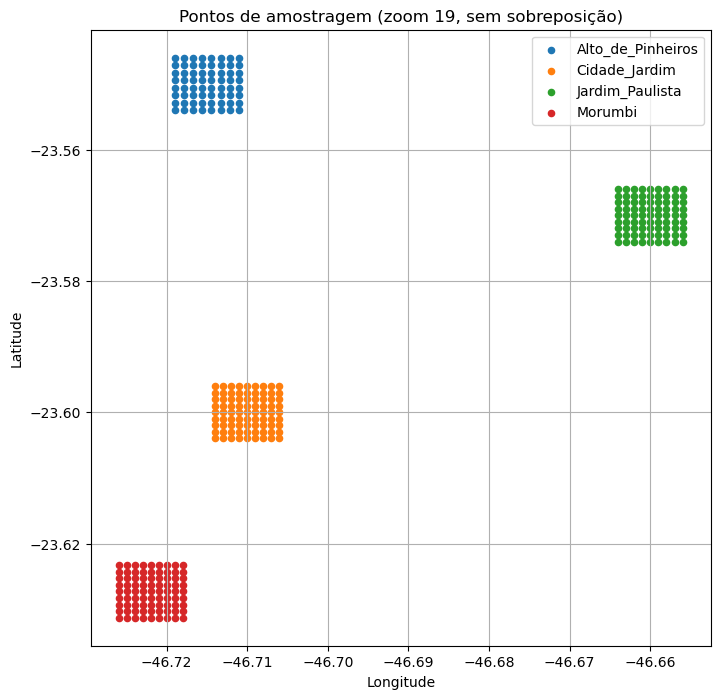

       lat        lon   region expected_density
0 -23.6313 -46.725899  Morumbi             alta
1 -23.6313 -46.724899  Morumbi             alta
2 -23.6313 -46.723899  Morumbi             alta
3 -23.6313 -46.722899  Morumbi             alta
4 -23.6313 -46.721899  Morumbi             alta
5 -23.6313 -46.720899  Morumbi             alta
6 -23.6313 -46.719899  Morumbi             alta
7 -23.6313 -46.718899  Morumbi             alta
8 -23.6313 -46.717899  Morumbi             alta
9 -23.6303 -46.725899  Morumbi             alta
           lat        lon             region expected_density
297 -23.547143 -46.712143  Alto_de_Pinheiros             alta
298 -23.547143 -46.711000  Alto_de_Pinheiros             alta
299 -23.546000 -46.719000  Alto_de_Pinheiros             alta
300 -23.546000 -46.717857  Alto_de_Pinheiros             alta
301 -23.546000 -46.716714  Alto_de_Pinheiros             alta
302 -23.546000 -46.715571  Alto_de_Pinheiros             alta
303 -23.546000 -46.714429  Alto_de_Pin

In [101]:
plt.figure(figsize=(8,8))
for bairro, subset in sampling_points.groupby('region'):
    plt.scatter(subset['lon'], subset['lat'], label=bairro, s=20)

save_path = '../results/sp_extract_images/sequential_method/sampling_points_map.png'
output_dir = os.path.dirname(save_path)
os.makedirs(output_dir, exist_ok=True)

plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Pontos de amostragem (zoom 19, sem sobreposição)")
plt.grid(True)
plt.savefig(save_path, dpi=150)
plt.show()

print(sampling_points.head(10))
print(sampling_points.tail(10))


In [102]:
OUTPUT_DIR2 = '../data/sao_paulo/sequential_method/images'
METADATA_PATH = '../data/sao_paulo/sequential_method/metadata.csv'
os.makedirs(OUTPUT_DIR2, exist_ok=True)

In [73]:
metadata2 = collect_satellite_images(
    sampling_points, 
    OUTPUT_DIR2
)


INICIANDO COLETA DE IMAGENS


Coletando: 100%|█████████████████████████████████████████████████████████████████████| 307/307 [11:47<00:00,  2.30s/it]


COLETA CONCLUÍDA
✓ Sucessos: 307
✗ Falhas: 0
📁 Imagens salvas em: ../dataset/sao_paulo2/images
📝 Metadata salvo em: ../dataset/sao_paulo2/metadata.csv
